In [2]:
%load_ext autoreload
%autoreload 2
import numpy as np
import networkx as nx
from tqdm import tqdm
import matplotlib.pyplot as plt

import sys
sys.path.append('../src')

from graph_utils import *
from performance_utils import *
from metropolis import *
from houdayer_algorithm import *
from sim_util import *

In [3]:
def critical_ratio(deg: int) -> float:
    ''' Finds the critical ratio to detect community, one should use r < crit_r.
    
        Parameters:
        ------------
        deg: int
            degree of the graph
        
        Output:
        ------------
        crit_r: float
            critical ratio for successful community detection
    '''
    return (np.sqrt(deg)-1) / (np.sqrt(deg)+1)

def generate_detectable_a_b(deg: int, r: float=None) -> tuple[float, float, float]:
    ''' Uniformly generate possible pair (a,b) so that the community is detectable,
        given that (a+b)/2 = deg.

        Parameters:
        -------------
        deg: int
            The degree of the graph
        
        Output: tuple[float, float]
            The numbers (a,b)
    '''
    rc = critical_ratio(deg)

    if r is None:
        r = np.random.uniform(low=0, high=rc)
    elif r > rc:
        print('Warning: the assigned ratio r = {:} is too large for community detection, need r < {:}.\nChange r value to critical value {:.2f}'.format(r, rc, rc))
        r = rc

    a = 2*deg / (1+r)
    b = a*r

    return a, b, r


def display_spec(N:int, d:int, a:float, b:float, r:float):
    print('Specs:')
    print(f'  Number of nodes (N) = {N}')
    print(f'  Degree of graph (d) = {d}')
    print(f'  Intra-group connect param (a) = {a}')
    print(f'  Inter-group connect param (b) = {b}')
    print(f'  Group connect ratio (r) = b/a = {r}')
    rc = critical_ratio(d)
    print(f'  Critical ratio (rc) = {rc} (for detectable communities)')



Specs:
  Number of nodes (N) = 800
  Degree of graph (d) = 100
  Intra-group connect param (a) = 199.9800019998
  Inter-group connect param (b) = 0.019998000199980003
  Group connect ratio (r) = b/a = 0.0001
  Critical ratio (rc) = 0.8181818181818182 (for detectable communities)


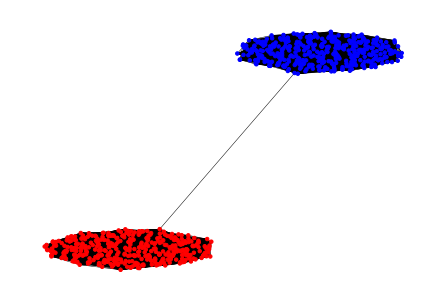

In [51]:
# Initialize random seed
np.random.seed(0)

# Define the parameters
N = 800      # number of nodes
d = 100       # degree

# Generate the basic parameters for simulation
a, b, r = generate_detectable_a_b(d, 1e-4)
display_spec(N,d,a,b,r)

true_group_label = generate_population(N)
G = graph_gen(true_group_label, a, b)

# G = build_graph(true_group_label, a, b)
draw_graph(G, true_group_label)
# nx.draw(G, node_size=50)

## Start Simulation

In [31]:
# Initialize the vector to start searching
x1_init, x2_init = generate_population(N), generate_population(N)
# Obtain the adjacency matrix
Adj = nx.to_numpy_array(G)

chain_1 = Metropolis(Adj, a, b, x1_init)
chain_2 = Metropolis(Adj, a, b, x2_init)

In [32]:

def Metropolis_Houdayer_step(G:nx.graph, ch1:Metropolis, ch2:Metropolis, num_metropolis_steps:int=1, num_houdayer_steps:int=1)->None:
    '''
    Apply Houdayer and Metropolis steps to the 2 chains. 
    The result will directly update the estimation stored in the 2 chains.

    Parameters
    -------------
    G: nx.graph
        The graph which we want to detect community on.
    ch1, ch2: Metropolis
        The 2 chains which we use to sample communities.
    num_metropolis_steps: int
        The number of Metropolis steps we perform
    num_houdayer_steps: int
        The number of Houdayer steps we perform
    
    '''


    # Update with Houdayer step
    for hou in range(num_houdayer_steps):
        ch1.x, ch2.x = houdayer_step(G, ch1.x, ch2.x)

    # Update with Metropolis step
    for met in range(num_metropolis_steps):
        ch1.step(); ch2.step()


In [52]:
def sim(G:nx.graph, ch1:Metropolis, ch2:Metropolis, true_group:np.ndarray, num_sim:int, num_iter:int, met_steps:int=1, hou_steps:int=1) -> tuple[list, list]:

    overlap_ch1 = []
    overlap_ch2 = []

    for s in tqdm(range(num_sim)):
        for itr in range(num_iter):
            Metropolis_Houdayer_step(G, ch1, ch2, met_steps, hou_steps)
                
        overlap_ch1.append(compute_overlap(true_group, ch1.x))
        overlap_ch2.append(compute_overlap(true_group, ch2.x))

        ch1.reset();ch2.reset()

    return overlap_ch1, overlap_ch2

 

  0%|          | 0/10 [00:00<?, ?it/s]/Users/chunzuo/Documents/tony/courses/2021Autumne/MarkovChain/project/Markov/notebook/../src/metropolis.py:77: RuntimeWarning: overflow encountered in exp
  a_xy = min(1., np.exp(exp))
100%|██████████| 10/10 [00:02<00:00,  4.82it/s]


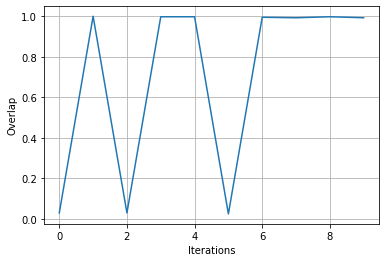

In [53]:
chain_1.reset();chain_2.reset()
ov1, ov2 = sim(G, chain_1, chain_2, true_group_label, 10, 1000, 5, 0)
plt.plot(ov1)
plt.xlabel('Iterations')
plt.ylabel('Overlap')
plt.grid()

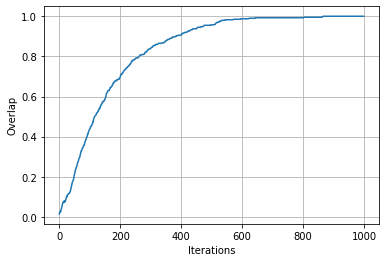

In [39]:
plt.plot(ov2)
plt.xlabel('Iterations')
plt.ylabel('Overlap')
plt.grid()